In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [190]:
# claims = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Claims.csv')
#members = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Members.csv')
#drug_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DrugCount.csv')
#lab_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LabCount.csv')
DY2 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y2.csv')
DY3 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y3.csv')
# Primary_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupPrimaryConditionGroup.csv')
# Procedure_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupProcedureGroup.csv')

In [188]:
members.count()
members.AgeAtFirstClaim.value_counts()

40-49    16111
70-79    14514
50-59    13329
60-69    12622
30-39    12435
10-19    11319
0-9      10791
20-29     8505
80+       7621
Name: AgeAtFirstClaim, dtype: int64

In [189]:
#Kiểm tra tính null của các cột khác
total_members = members.isnull().sum().sort_values(ascending=False)
percent_members = (members.isnull().sum()/members.isnull().count()).sort_values(ascending=False)
missing_data_mem = pd.concat([total_members, percent_members], axis=1, keys=['Total', 'Percent'])
missing_data_mem.head()

,Total,Percent
Sex,17552,0.155
AgeAtFirstClaim,5753,0.051
MemberID,0,0.000


In [50]:
drug_count.count()
drug_count.DrugCount.value_counts()

1     263501
2     188559
3     129881
4      87783
5      57768
7+     54018
6      36731
Name: DrugCount, dtype: int64

In [51]:
total_drug = drug_count.isnull().sum().sort_values(ascending=False)
percent_drug = (drug_count.isnull().sum()/drug_count.isnull().count()).sort_values(ascending=False)
missing_data_drug = pd.concat([total_drug, percent_drug], axis=1, keys=['Total', 'Percent'])
missing_data_drug.head()

,Total,Percent
DrugCount,0,0.000
DSFS,0,0.000
Year,0,0.000
MemberID,0,0.000


In [52]:
lab_count.count()
lab_count.LabCount.value_counts()

1      93744
2      54183
3      43472
4      38815
5      34900
6      27705
10+    23110
7      20591
8      14885
9      10079
Name: LabCount, dtype: int64

In [53]:
DY2.count()

MemberID           76038
ClaimsTruncated    76038
DaysInHospital     76038
dtype: int64

In [54]:
DY3.count()

MemberID           71435
ClaimsTruncated    71435
DaysInHospital     71435
dtype: int64

In [55]:
members.head()

,MemberID,AgeAtFirstClaim,Sex
0,14723353,70-79,M
1,75706636,70-79,M
2,17320609,70-79,M
3,69690888,40-49,M
4,33004608,0-9,M


In [56]:
drug_count.head()

,MemberID,Year,DSFS,DrugCount
0,48925661,Y2,9-10 months,7+
1,90764620,Y3,8- 9 months,3
2,61221204,Y1,2- 3 months,1
3,63628544,Y3,1- 2 months,1
4,46949606,Y2,10-11 months,3


In [57]:
lab_count.head()

,MemberID,Year,DSFS,LabCount
0,69258001,Y3,2- 3 months,1
1,10143167,Y1,0- 1 month,2
2,1054357,Y1,0- 1 month,6
3,56583841,Y3,6- 7 months,4
4,70967047,Y2,0- 1 month,2


In [58]:
DY2.head()

,MemberID,ClaimsTruncated,DaysInHospital
0,24027423,0,0
1,98324177,0,0
2,33899367,1,1
3,5481382,0,1
4,69908334,0,0


In [59]:
DY3.head()

,MemberID,ClaimsTruncated,DaysInHospital
0,90963501,0,0
1,85160905,0,0
2,45496648,0,0
3,45162557,0,0
4,68793937,0,0


['Year', 'DSFS', 'DrugCount']


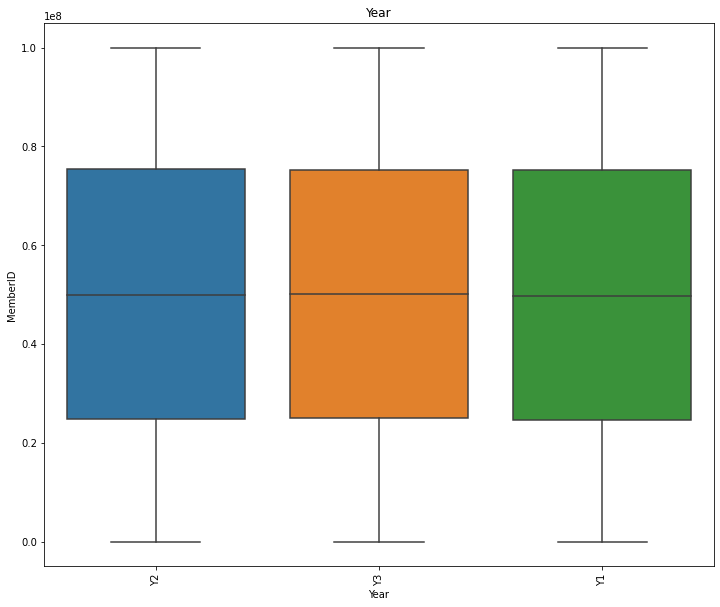

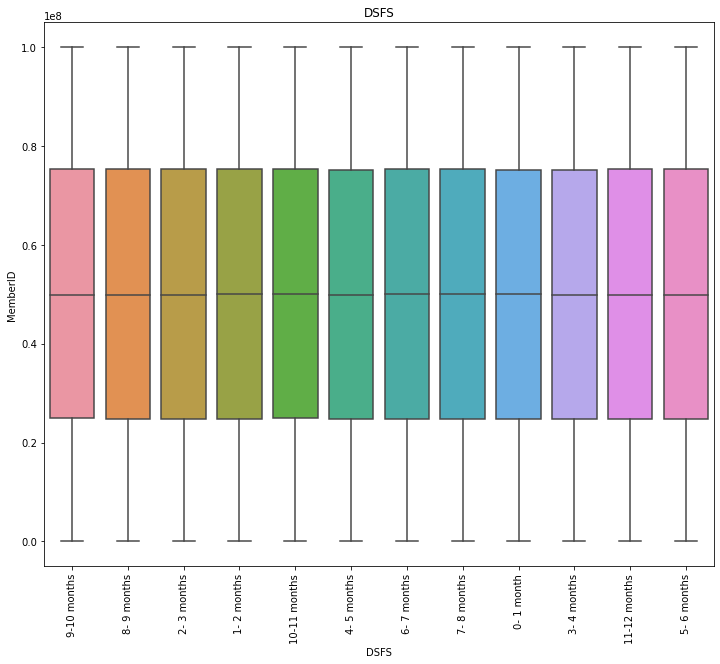

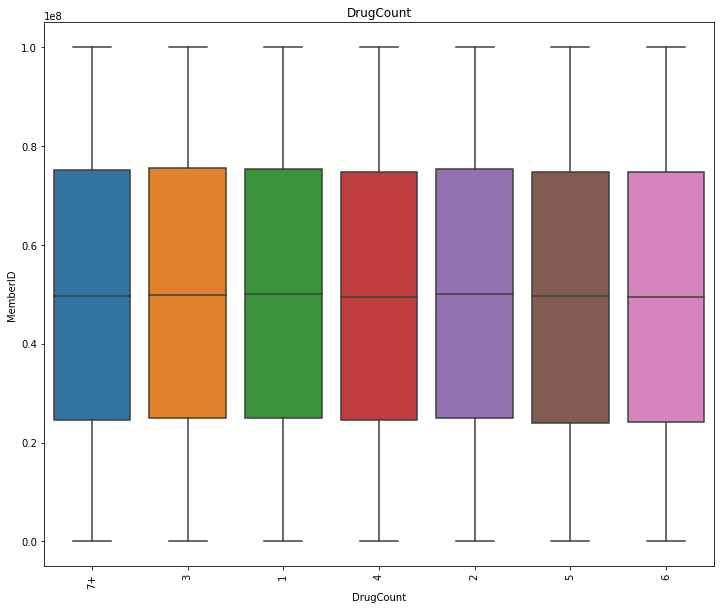

In [19]:
#Load hết tất cả các cột categorical chạy boxplot
#Theo drug count
cate = ['object']
cate_drugcolumns = list(drug_count.select_dtypes(include = cate).columns)
print(cate_drugcolumns)

for col in cate_drugcolumns:
    plt.figure(figsize = (12, 10))
    sns.boxplot(x=col,y='MemberID', data = drug_count)
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show

['Year', 'DSFS', 'LabCount']


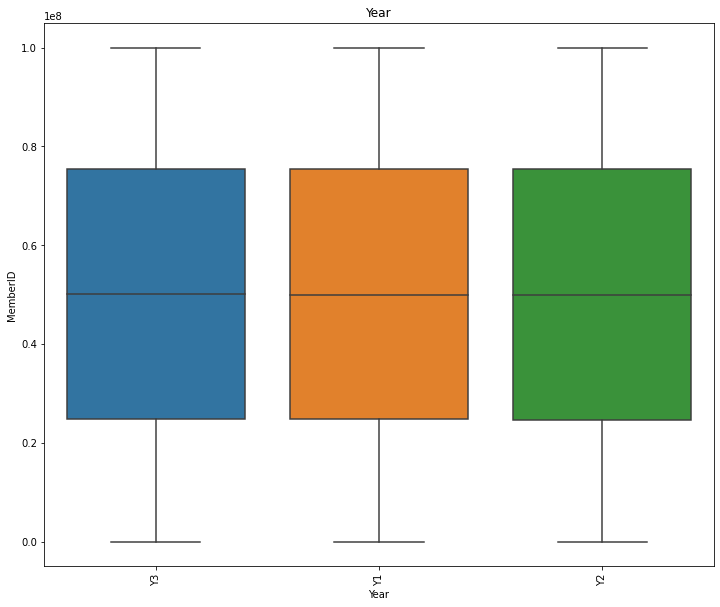

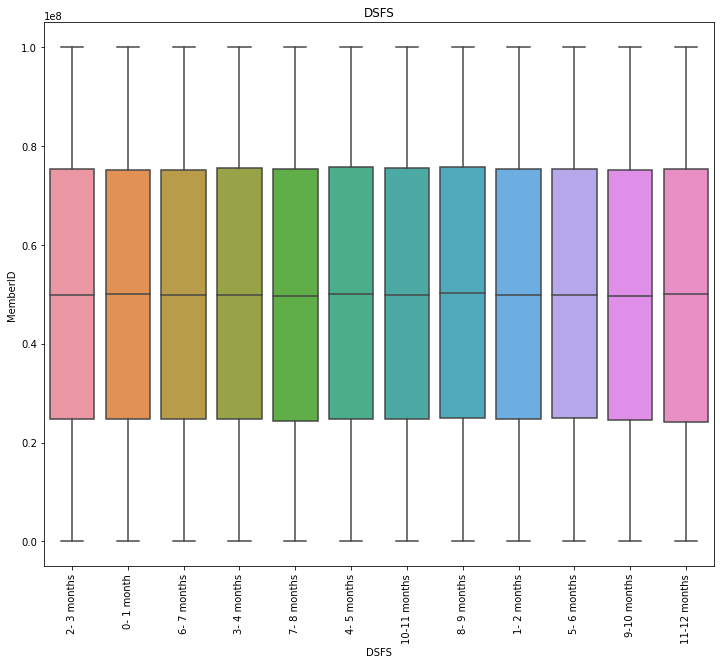

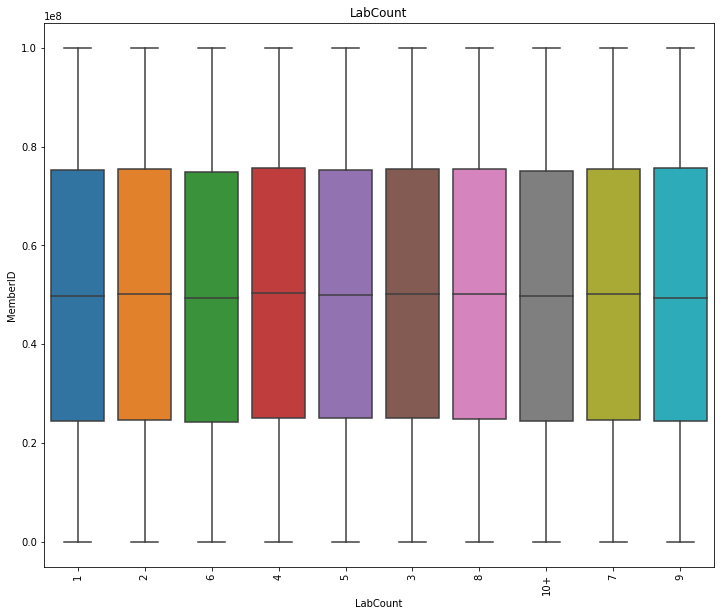

In [20]:
#Theo lab_count
cate = ['object']
cate_labcolumns = list(lab_count.select_dtypes(include = cate).columns)
print(cate_labcolumns)

for col in cate_labcolumns:
    plt.figure(figsize = (12, 10))
    sns.boxplot(x=col,y='MemberID', data = lab_count)
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show

In [60]:
#Biến đổi biến DSFS thành số 
def DSFS_int(s):
    try:   
        if len(s.split(" month")[0]) == 4:
            return int(s.split(" month")[0][3])
        elif len(s.split(" month")[0]) == 5:
            return int(s.split(" month")[0][3:])
    except:
        pass

In [61]:
drug_count['DSFS']= drug_count['DSFS'].apply(lambda x: DSFS_int(x))
drug_count.groupby('DSFS').count()

,MemberID,Year,DrugCount
DSFS,,,
0,55984,55984,55984
1,108980,108980,108980
2,81395,81395,81395
3,78528,78528,78528
4,77044,77044,77044
5,73325,73325,73325
6,72274,72274,72274
7,69350,69350,69350
8,67433,67433,67433


In [62]:
lab_count['DSFS']= lab_count['DSFS'].apply(lambda x: DSFS_int(x))
lab_count.groupby('DSFS').count()

,MemberID,Year,LabCount
DSFS,,,
0,20126,20126,20126
1,97581,97581,97581
2,32279,32279,32279
3,30305,30305,30305
4,29750,29750,29750
5,26432,26432,26432
6,27460,27460,27460
7,26103,26103,26103
8,24724,24724,24724


In [63]:
#Kiểm tra 2 bảng drug_count và lab_count
drug_count.DrugCount.value_counts()

1     263501
2     188559
3     129881
4      87783
5      57768
7+     54018
6      36731
Name: DrugCount, dtype: int64

In [64]:
lab_count.LabCount.value_counts()

1      93744
2      54183
3      43472
4      38815
5      34900
6      27705
10+    23110
7      20591
8      14885
9      10079
Name: LabCount, dtype: int64

In [65]:
# Xóa dấu + ở các biến DrugCount và LabCount
def del_int(s):
        if '+' in s:
            return int(s.split("+")[0][:])
        if type(s) != int:
            return int(s)

In [66]:
del_int('10+ ')

10

In [67]:
drug_count['DrugCount']= drug_count['DrugCount'].apply(lambda x: del_int(x))
drug_count.groupby('DrugCount').count()

,MemberID,Year,DSFS
DrugCount,,,
1,263501,263501,263501
2,188559,188559,188559
3,129881,129881,129881
4,87783,87783,87783
5,57768,57768,57768
6,36731,36731,36731
7,54018,54018,54018


In [68]:
lab_count['LabCount']= lab_count['LabCount'].apply(lambda x: del_int(x))
lab_count.groupby('LabCount').count()

,MemberID,Year,DSFS
LabCount,,,
1,93744,93744,93744
2,54183,54183,54183
3,43472,43472,43472
4,38815,38815,38815
5,34900,34900,34900
6,27705,27705,27705
7,20591,20591,20591
8,14885,14885,14885
9,10079,10079,10079


In [69]:
drug_count.head()

,MemberID,Year,DSFS,DrugCount
0,48925661,Y2,0,7
1,90764620,Y3,9,3
2,61221204,Y1,3,1
3,63628544,Y3,2,1
4,46949606,Y2,11,3


In [70]:
lab_count.head()

,MemberID,Year,DSFS,LabCount
0,69258001,Y3,3,1
1,10143167,Y1,1,2
2,1054357,Y1,1,6
3,56583841,Y3,7,4
4,70967047,Y2,1,2


In [71]:
new_drugcount = drug_count.groupby(['MemberID','Year']).agg({
    'DrugCount':['sum','count'],
    'DSFS':['count','max','min']
}).reset_index()

new_drugcount.columns =['MemberID','Year','Drug_total','Drug_count','DSFS_drugcount','DSFS_drugmax','DSFS_drugmin']

new_drugcount.head(10)

,MemberID,Year,Drug_total,Drug_count,DSFS_drugcount,DSFS_drugmax,DSFS_drugmin
0,210,Y1,5,3,3,5,1
1,210,Y3,5,4,4,9,6
2,3197,Y1,5,4,4,12,2
3,3197,Y2,3,2,2,2,1
4,3197,Y3,6,5,5,12,0
5,3713,Y2,17,4,4,4,1
6,3741,Y2,35,11,11,11,0
7,3889,Y1,30,10,10,11,0
8,4048,Y3,1,1,1,2,2
9,4187,Y1,61,10,10,9,0


In [60]:
new_drugcount.to_csv("new_drugcount.csv", index=False)

In [72]:
new_labcount = lab_count.groupby(['MemberID','Year']).agg({
    'LabCount':['sum','count'],
    'DSFS':['count','max','min']
}).reset_index()

new_labcount.columns =['MemberID','Year','Lab_total','Lab_count','DSFS_labcount','DSFS_labmax','DSFS_labmin']
new_labcount.head(10)

,MemberID,Year,Lab_total,Lab_count,DSFS_labcount,DSFS_labmax,DSFS_labmin
0,210,Y1,2,1,1,2,2
1,210,Y2,1,1,1,1,1
2,210,Y3,1,1,1,3,3
3,3197,Y2,2,1,1,2,2
4,3713,Y2,9,2,2,9,2
5,3741,Y2,11,5,5,8,1
6,3889,Y1,10,1,1,1,1
7,4048,Y3,16,2,2,2,1
8,5187,Y3,1,1,1,3,3
9,8213,Y2,4,1,1,1,1


In [61]:
new_labcount.to_csv("new_labcount.csv", index=False)

In [ ]:
#Với cả drug count và lab count: 
#Drug/Labcount: số thuốc/xét nghiệm trong năm của 1 bệnh nhân
#DSFS count - Drug/LabCount(count): Số lần đi khám trong năm/Số lần lấy thuốc/xét nghiệm trong năm
#DSFS max/min: Lần xa nhất/gần nhất trong năm đi khám lại, so với lần đầu.

In [28]:
#Kiểm tra bảng member

In [111]:
members.dtypes

MemberID            int64
AgeAtFirstClaim    object
Sex                object
dtype: object

In [135]:
members.AgeAtFirstClaim.value_counts()

40-49    16111
70-79    14514
50-59    13329
60-69    12622
30-39    12435
10-19    11319
0-9      10791
20-29     8505
80+       7621
Name: AgeAtFirstClaim, dtype: int64

In [136]:
members.Sex.value_counts()

F    51482
M    43966
Name: Sex, dtype: int64

In [175]:
#Biến đổi biến tuổi thành int
def Age1st_int(s):
    try:
        if '-' in s:
            return round((int(s.split('-')[0]) + int(s.split('-')[1])) / 2) + 1
        elif '+' in s:
            return int(s.split("+")[0][:])
        elif type(s) != int:
            return int(s)
    except:
        pass

In [176]:
round((int('70-79'.split('-')[0]) + int('70-79'.split('-')[1])) / 2) + 1

75

In [177]:
members['AgeAtFirstClaim']= members['AgeAtFirstClaim'].apply(lambda x: Age1st_int(x))
members.groupby('AgeAtFirstClaim').count()

,MemberID,Sex
AgeAtFirstClaim,,
5.000,10791,9662
15.000,11319,10200
25.000,8505,7465
35.000,12435,11089
45.000,16111,14290
55.000,13329,11508
65.000,12622,10617
75.000,14514,12067
80.000,7621,5773


In [178]:
# Không thể khai thác biến Age này theo cách tính toán được, nên sẽ xét dưới dạng categorical
# Sử dụng binary để xét điều kiện theo kiểu boolean 
new_members = members.pivot(index ='MemberID', columns ='AgeAtFirstClaim') 
new_members.head()

Sex                                                          \
AgeAtFirstClaim  NaN 5.000  15.000 25.000 35.000 45.000 55.000 65.000 75.000   
MemberID                                                                       
4                NaN      M    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
210              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3197             NaN      F    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3457             NaN      M    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3713             NaN    NaN    NaN    NaN    NaN      F    NaN    NaN    NaN   

                        
AgeAtFirstClaim 80.000  
MemberID                
4                  NaN  
210                NaN  
3197               NaN  
3457               NaN  
3713               NaN

In [179]:
new_members2 = pd.DataFrame()
new_members2 = members

In [180]:
# Thay đổi từng dòng theo điều kiện
new_members2 = pd.DataFrame()
new_members2 = members
def Age_binary():
    new_members2['05_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==5.000, 1, 0)
    new_members2['15_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==15.000, 1, 0)
    new_members2['25_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==25.000, 1, 0)
    new_members2['35_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==35.000, 1, 0)
    new_members2['45_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==45.000, 1, 0)
    new_members2['55_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==55.000, 1, 0)
    new_members2['65_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==65.000, 1, 0)
    new_members2['75_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==75.000, 1, 0)
    new_members2['80_yrsold'] = np.where(new_members2['AgeAtFirstClaim']==80.000, 1, 0)
    new_members2['missing_age'] = np.where(new_members2['AgeAtFirstClaim'].isnull(), 1, 0)
    return

updateAge()
new_members2.head()

,MemberID,AgeAtFirstClaim,Sex,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age
0,14723353,75.000,M,0,0,0,0,0,0,0,1,0,0
1,75706636,75.000,M,0,0,0,0,0,0,0,1,0,0
2,17320609,75.000,M,0,0,0,0,0,0,0,1,0,0
3,69690888,45.000,M,0,0,0,0,1,0,0,0,0,0
4,33004608,5.000,M,1,0,0,0,0,0,0,0,0,0


In [181]:
def Sex_binary():
    new_members2['Sex_male'] = np.where(new_members2['Sex']=='M', 1, 0)
    new_members2['Sex_female'] = np.where(new_members2['Sex']=='F', 1, 0)
    new_members2['missing_sex'] = np.where(new_members2['Sex'].isnull(), 1, 0)
    return

Sex_binary()
new_members2.head()

,MemberID,AgeAtFirstClaim,Sex,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age,Sex_male,Sex_female,missing_sex
0,14723353,75.000,M,0,0,0,0,0,0,0,1,0,0,1,0,0
1,75706636,75.000,M,0,0,0,0,0,0,0,1,0,0,1,0,0
2,17320609,75.000,M,0,0,0,0,0,0,0,1,0,0,1,0,0
3,69690888,45.000,M,0,0,0,0,1,0,0,0,0,0,1,0,0
4,33004608,5.000,M,1,0,0,0,0,0,0,0,0,0,1,0,0


In [182]:
new_members2.drop(['AgeAtFirstClaim', 'Sex'], axis='columns', inplace=True)

In [184]:
new_members2.head(5)

,MemberID,5.000,15.000,25.000,35.000,45.000,55.000,65.000,75.000,80.000,missing_age,Sex_male,Sex_female,missing_sex
0,14723353,0,0,0,0,0,0,0,1,0,0,1,0,0
1,75706636,0,0,0,0,0,0,0,1,0,0,1,0,0
2,17320609,0,0,0,0,0,0,0,1,0,0,1,0,0
3,69690888,0,0,0,0,1,0,0,0,0,0,1,0,0
4,33004608,1,0,0,0,0,0,0,0,0,0,1,0,0


In [185]:
new_members2.to_csv("new_members2.csv", index=False)

In [194]:
Target_pastyear = pd.DataFrame()
Target_pastyear = DY2
Target_pastyear.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,76038.000,76038.000,76038.000
mean,49947611.565,0.052,0.467
std,28901449.395,0.222,1.612
min,210.000,0.000,0.000
25%,24837194.750,0.000,0.000
50%,49907210.000,0.000,0.000
75%,75101120.750,0.000,0.000
max,99998627.000,1.000,15.000


In [195]:
Target_curryear = pd.DataFrame()
Target_curryear = DY3
Target_curryear.describe()

,MemberID,ClaimsTruncated,DaysInHospital
count,71435.000,71435.000,71435.000
mean,49939856.726,0.057,0.438
std,28940770.025,0.231,1.532
min,4.000,0.000,0.000
25%,24778132.500,0.000,0.000
50%,49953793.000,0.000,0.000
75%,75219855.000,0.000,0.000
max,99998824.000,1.000,15.000
